In [ ]:
Task 2


In [1]:
!pip install tensorflow-datasets --quiet
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

tf.random.set_seed(42)
IMG_SIZE = 160
BATCH_SIZE = 16


In [2]:
# === Load Tiny Subset of PlantVillage ===
ds_full, ds_info = tfds.load('plant_village', split='train', with_info=True, as_supervised=True)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

N_TRAIN = 600
N_VAL = 200
N_TEST = 200

ds_small = ds_full.shuffle(5000).take(N_TRAIN + N_VAL + N_TEST)

train_raw = ds_small.take(N_TRAIN)
val_raw   = ds_small.skip(N_TRAIN).take(N_VAL)
test_raw  = ds_small.skip(N_TRAIN + N_VAL).take(N_TEST)
print('Dataset loaded: small subset ready.')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.GCS3BA_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Dataset loaded: small subset ready.


In [3]:
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
AUTO = tf.data.AUTOTUNE

def prep(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return preprocess(img), label

def make_ds(ds, train=True):
    ds = ds.map(prep, num_parallel_calls=AUTO)
    if train:
        ds = ds.shuffle(500)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

train_ds = make_ds(train_raw, True)
val_ds   = make_ds(val_raw, False)
test_ds  = make_ds(test_raw, False)
print('Datasets prepared.')


Datasets prepared.


In [4]:
# === Build MobileNetV2 Model ===
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet'
)
base.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,342,438 (8.94 MB)

 Trainable params: 84,454 (329.90 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/6
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2037 - loss: 3.2002 - val_accuracy: 0.5700 - val_loss: 1.7474
Epoch 2/6
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - accuracy: 0.5562 - loss: 1.8257 - val_accuracy: 0.6700 - val_loss: 1.2777
Epoch 3/6
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step - accuracy: 0.7129 - loss: 1.1454 - val_accuracy: 0.8050 - val_loss: 0.8054
Epoch 4/6
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 447ms/step - accuracy: 0.7803 - loss: 0.8053 - val_accuracy: 0.8000 - val_loss: 0.7756
Epoch 5/6
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 591ms/step - accuracy: 0.8139 - loss: 0.7328 - val_accuracy: 0.8650 - val_loss: 0.5273
Epoch 6/6
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 562ms/step - accuracy: 0.8421 - loss: 0.5571 - val_accuracy: 0.8400 - val_loss: 0.5408


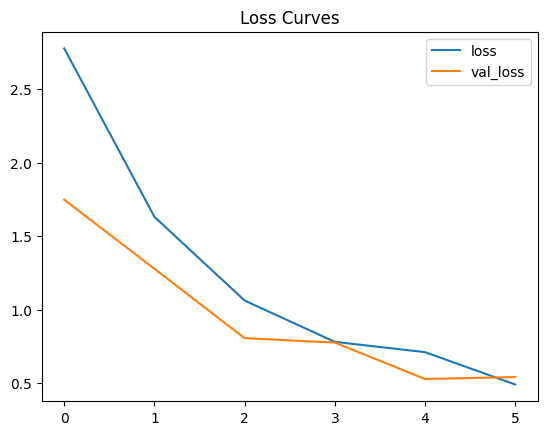

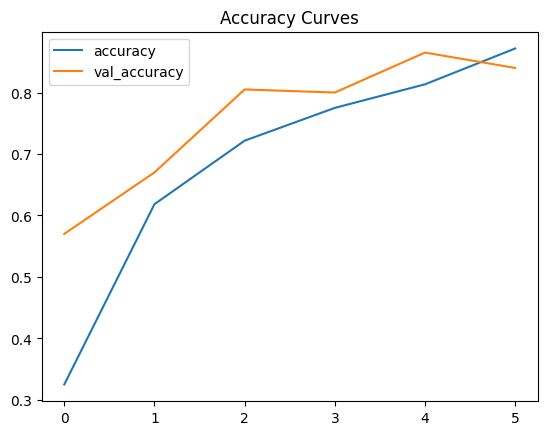

In [5]:
# === Train Model ===
history = model.fit(train_ds, validation_data=val_ds, epochs=6)

pd.DataFrame(history.history)[['loss','val_loss']].plot(title='Loss Curves'); plt.show()
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(title='Accuracy Curves'); plt.show()


Test Accuracy: 0.87


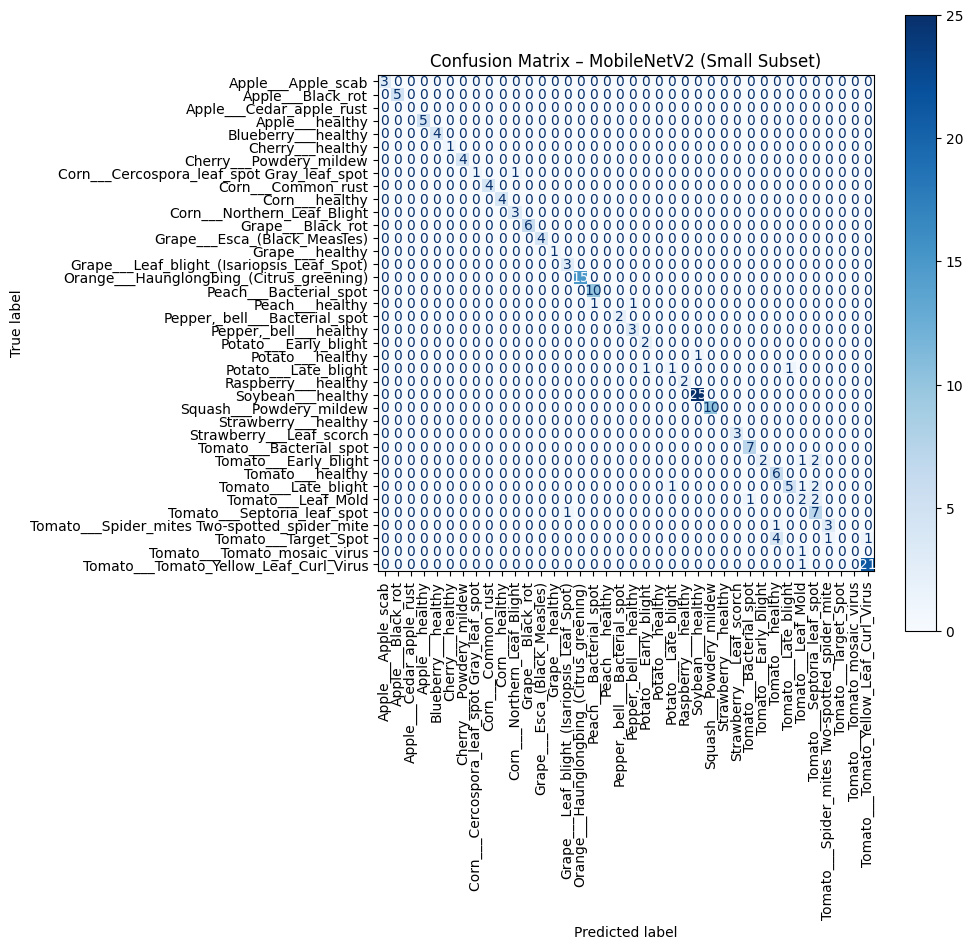

In [6]:
# === Evaluate on Test Set ===
y_true, y_pred = [], []

for imgs, labels in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
print('Test Accuracy:', acc)

# Fix: Pass the full range of labels to confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title('Confusion Matrix – MobileNetV2 (Small Subset)')
plt.show()
